---

Libreta n° 4 sobre el trabajo de investigación:

**"Estimación de la evapotranspiración espacio-temporal en arrozales usando imágenes satelitales, Departamento de Lambayeque"**

Autor: Cesar Francisco Vilca Gamarra 

Repositorio alojado en [GitHub](https://github.com/vilcagamarracf/Inv_arroz_METRIC) 

Marzo, 2022

---

# Selección de pixeles

**Referencia**
- Bhattarai, N., Quackenbush, L. J., Im, J., & Shaw, S. B. (2017). A new optimized algorithm for automating endmember pixel selection in the SEBAL and METRIC models. *Remote Sensing of Environment*, 196, 178-192. [10.1016/j.rse.2017.05.009](http://dx.doi.org/10.1016/j.rse.2017.05.009)

**Selección de pixeles fríos y calientes**

- In terms of identifying a cold pixel, the search method seeks to find
the coldest pixels with the highest NDVI. There is not necessarily one
pixel that has both the lowest Ts and the highest NDVI. Thus, instead
of searching for a single pixel, the method searches for a subset of pixels that have both low NDVI and high Ts.
- Specifically, the cold pixel selection process starts by searching for **pixels that have a Ts value within the lowest n1% (e.g. n1 = 1) of the Ts histogram** and NDVI values in
the top n2% (e.g. n2 = 1) of the NDVI histogram.
- The search continues by increasing the value of n2 first (i.e. increasing n2 in increments of 1 up to 10, keeping n1 = 1) and then increasing n1 (up to 10 in increments of 1) until 10 pixels are identified.

## Inicio

In [1]:
# ------------------------------------------------
# Importando librerías utilizadas
# ------------------------------------------------

import ee
ee.Initialize()

import os
import numpy as np
import math
import pandas as pd
from pprint import pprint

import geemap
import geemap.colormaps as cmp # Paletas para visualización de imágenes

# Funciones en archivo Funciones.py
from funciones import *

In [16]:
# ------------------------------------------------------------------------------------------------
# Pruebas: En caso de realizar alguna edición al archivo 'funciones.py' realizar lo siguiente:
# ------------------------------------------------------------------------------------------------

# import importlib 
# import sys

# importlib.reload(sys.modules['funciones']) # Importa las funciones del archivo con las modificaciones aplicadas
# from funciones import *    

In [2]:
# ------------------------------------------------
# Importando áreas de estudio
# ------------------------------------------------

# Importar asset público: Distrito de Ferreñafe
asset_dist = ee.FeatureCollection('users/CesarVilca/distritos')
dist_fcol = asset_dist.filterMetadata('DISTRITO', 'equals', 'FERREÑAFE')
roi = dist_fcol.geometry().bounds()   # ee.Geometry tipo caja

# Importar shapefile de Áreas voladas (archivo en local)
ruta_ferrenafe = r'input/Ferreñafe_areas_2.shp'

# Lectura como FeatureCollection con geemap
predios_agricolas = geemap.shp_to_ee(ruta_ferrenafe)
predios_vis = ee.Image().paint(predios_agricolas, 2, 2)  # Ver solo bordes, no relleno

predios_bound = predios_agricolas.geometry().bounds()
predios_bound_vis = ee.Image().paint(predios_bound, 1, 1)  # Ver solo bordes, no relleno

# type(predios_agricolas) # Comprobación

# ------------------------------------------------
# Parámetros de visualización de mapas con geemap
# ------------------------------------------------

# Para imágenes Landsat 8 y 9 TOA
vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']}

# Paletas de colores
albedo_cmap = ['68181f', 'd6604d', 'f9dbc7', 'd1e5f0', '2166ac', '053061']  # 0 - 0.5
ndvi_cmap = ['ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03']  # -0.2 - 1  '0048fb',
ts_cmap = ['fefccc', 'fbd976', 'f08c39', 'ea4a33', 'e43d32', '812026']  # 280 - 330 en K o 6.85 - 56.85 en °C
rn_cmp = ['560e0d', 'fd5903', 'fbfe04', '3aff01', '01feef', '0000fe', 'fd6dfd', 'ffffff']
rn_cmp_r = ['ffffff', 'fd6dfd', '0000fe', '01feef', '3aff01', 'fbfe04', 'fd5903', '560e0d']

# -------------------------------------------------------
# Parámetros de visualización de gráficas con matplotlib
# -------------------------------------------------------

plt.rcParams['font.family'] = 'serif'  #'serif', 'Arial'  # default es 'sans-serif'
# plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.dpi'] = 72

## Función 

In [3]:
def getRadiacionNeta(img_ee, roi, dem, lai_method, albedo_method, HR):

    """Obtener mapa de Radiación Neta

    Parametros
    ----------
    img_ee : ee.Image
    roi : ee.Geometry
    dem : ee.Image

    Retorna
    -------
    R_n : ee.Image
    img_sr_tasumi : ee.Image
    img_productos : ee.Image
    d2 : ee.Number
    doy : ee.Number
    """

    # =================================================================
    # Constantes
    # =================================================================
    
    # Factor de conversión de grados a radianes
    factor_rad = ee.Number(math.pi/180)

    # Fechas
    img_date = img_ee.date() # ee.Date
    doy = img_date.getRelative('day', 'year') # ee.Number
    fecha = img_date.format('YYYY-MM-dd').getInfo() # string

    # =================================================================
    # Procesamiento
    # =================================================================

    # Procesar imagen RAW a TOA
    img_toa = convert_RAW_to_TOA(img_ee).clip(roi) # ee.Image
    
    # Índices de vegetación (eq. 23, 19 y 18)
    img_ndvi = get_ndvi_L8(img_toa)
    
    if lai_method == 0:
        img_savi = get_savi_L8(img_toa, L=0.1)
        img_lai  = get_lai_L8(img_savi)
        
    if lai_method == 1:
        img_savi = get_savi_L8(img_toa, L=0.5)
        img_lai  = get_lai_L8(img_savi)
    
    # Obtener LAI mediante relación NDVI - IAF
    if lai_method == 2:
        img_savi = get_savi_L8(img_toa) 
        img_lai = img_ndvi.multiply(2.1362).add(0.0869).rename('LAI') # Usando 10 datos (1 fecha - excel de Martin)
        
    if lai_method == 3:
        img_savi = get_savi_L8(img_toa) 
        img_lai = img_ndvi.expression('(2.3523*img_ndvi)**2 - 1.9013*img_ndvi + 1.7714', 
                                      {'img_ndvi': img_ndvi.select('NDVI')}
                                      ).rename('LAI') # Usando 30 datos

    img_lai = img_lai.where(img_lai.lte(0), 0)
    
    # A partir del DEM: Pendiente y Aspect [rad]
    img_dem_clippped = dem.clip(roi)
    img_slopes = ee.Terrain.slope(img_dem_clippped) # grados
    img_slopes_rad = img_slopes.multiply(factor_rad)  # ee.Image, radianes 
        
    img_aspect = ee.Terrain.aspect(img_dem_clippped) # grados
    img_aspect_rad = img_aspect.multiply(factor_rad)  # ee.Image, radianes


    # Ángulos Declinación, Latitud y Horario [rad]
    angle_decl, latitud, angle_hra = get_decl_lat_hra(img_ee, roi, doy)


    # Parámetro: Emisividad e_0 (eq. 17)
    e_nb, e_0 = get_emisividades(img_ndvi, img_lai)

    # =================================================================
    # Parámetro: Radiación de onda corta entrante 
    # =================================================================
    
    # Requiere: t_sw, d2, cos_theta_rel 
    # t_sw requiere: P_air, w, cos_theta_hor
    # w requiere: e_s

    # 1. d2 INVERSE RELATIVE DISTANCE EARTH-SUN (eq. 9)
    d2 = ee.Number.expression('1/( 1+0.033*cos(doy*2*pi/365) )',
                              {'doy': doy, 'pi': math.pi})

    # 2. cos_theta_rel [rad] (eq. 7)
    cos_theta_rel = get_cos_theta(angle_decl, 
                                  latitud, 
                                  angle_hra, 
                                  img_slopes_rad, 
                                  img_aspect_rad)

    # 3. t_sw (eq. 4)
    # 3.1. P_air Atmospheric Pressure [kPa] (eq. 5)
    P_air = dem.expression('101.3*( (293-0.0065*z)/293 )**5.26', 
                           {'z': dem.select(0)}) # ee.Image

    # 3.2. cos_theta_hor (eq. 8)
    cos_theta_hor = get_cos_theta(angle_decl, 
                                  latitud, 
                                  angle_hra, 
                                  slope_rad=0, 
                                  aspect_rad=0)
    
    # 3.3. w Water in the atmosphere [mm]
    # 3.3.1. Temperatura de superficie (eq. 20)
    ts = get_surface_temp(img_toa, e_nb)      # [K]
    ts_c = ts.subtract(273.15).rename('Ts_c') # [°C]

    # 3.3.2. Near-surface vapor pressure ea [kPa]
    # Ojo temperatura se requiere en °C
    # e0_eq = '6.112*exp(17.67*t / (t + 243.5))' # https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf
    e0_eq = '0.6108*exp(17.27*t / (t + 237.3))' # FAO 56, Allen (2012) https://www.fao.org/3/x0490s/x0490s01.pdf
    e0 = ts_c.expression(e0_eq, {'t': ts_c.select('Ts_c')})
    ea = e0.multiply(HR/100).rename('vapor_pressure')

    # 3.3.3. Agua precipitable en la atmósfera w [mm] Garrison & Adler (1990)
    w = ea.expression('0.14*ea*P + 2.1', {'ea':ea, 'P':P_air}).rename('w')
    
    # 3.3.4. t_sw: broad-band atmospheric transmissivity (eq. 4), ASCE-EWRI (2005)
    t_sw = P_air.expression('''
                            0.35 + 0.627*exp(
                            - 0.00146*P_air/(Kt*cos_theta_hor) 
                            - 0.075*(W/cos_theta_hor)**0.4
                            )
                            ''',
                            {'P_air':P_air, 'Kt':1, 'cos_theta_hor':cos_theta_hor, 'W':w}
                            ).rename('t_sw')
    
    # Finalmente: R_s_incoming (eq. 3)
    R_s_in = cos_theta_rel.expression('1367*cos_theta_rel*t_sw/d2',
                                      {'cos_theta_rel':cos_theta_rel, 't_sw':t_sw, 'd2':d2}
                                      ).rename('R_s_in')

    # =================================================================
    # Parámetro: Radiación de onda larga entrante
    # =================================================================

    # ea: effective atmospheric emissivity (eq. 25)
    atm_emissivity_ea = t_sw.expression('0.85*(- log(t_sw))**0.09',
                                        {'t_sw': t_sw}
                                        ).rename('atm_emissivity_ea')

    # Finalmente: R_l_in (eq. 24)
    R_l_in = atm_emissivity_ea.multiply(5.67E-08).multiply(ts.pow(4)).rename('R_l_in')

    # =================================================================
    # Parámetro: Radiación de onda larga saliente (eq.  16)
    # =================================================================

    R_l_out = e_0.multiply(5.67E-08).multiply(ts.pow(4)).rename('R_l_out')

    # =================================================================
    # Parámetro: Albedo
    # =================================================================

    # Corrección atmosférica - Tasumi et al. (2007) (eqs. 10 - 14)
    img_sr_tasumi = convert_TOA_to_SR(img_toa, P_air, w, cos_theta_hor)

    # Albedo (eq. 15)
    img_albedo = get_albedo(img_sr_tasumi, albedo_method)

    # Radiación Neta (eq. 2)
    Rn = img_albedo.expression(
        '(1-albedo)*R_s_in + (R_l_in - R_l_out) - (1-e_0)*R_l_in',
        {'albedo':img_albedo,
         'R_s_in':R_s_in,
         'R_l_in':R_l_in,
         'R_l_out':R_l_out,
         'e_0':e_0}
         ).rename('R_n')

    img_Rn = Rn.addBands([R_s_in, R_l_in, R_l_out])

    # Juntar los parámetros obtenidos en una sola imagen
    img_productos = ee.Image([
        img_ndvi.select('NDVI'),
        img_savi.select('SAVI'),
        img_lai.select('LAI'),
        img_albedo,
        ts,
        ts_c,
        t_sw,
        e_0,
        e_nb,
        cos_theta_rel,
        cos_theta_hor,
        img_slopes,
        dem
        ])

    img_productos_dict = {
        'img_Rn': img_Rn,
        'img_SR': img_sr_tasumi,
        'img_toa': img_toa,
        'img_productos': img_productos,
        'd2': d2,
        'doy': doy,
        'fecha': fecha
    }
        
    return img_productos_dict

## Procesamiento

In [4]:
# =============================================================
# Parámetros de visualización de mapas con geemap
# =============================================================

# Diccionario de visualización de imágenes Landsat 8 y 9 TOA
vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 

# Paletas de colores
albedo_cmap = ['68181f', 'd6604d', 'f9dbc7', 'd1e5f0', '2166ac', '053061'] # 0 - 0.5
ndvi_cmap = ['ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03'] # -0.2 - 1  '0048fb',
ts_cmap = ['fefccc', 'fbd976', 'f08c39', 'ea4a33', 'e43d32', '812026'] # 280 - 330 en K o 6.85 - 56.85 en °C
rn_cmp = ['560e0d', 'fd5903', 'fbfe04', '3aff01', '01feef', '0000fe', 'fd6dfd', 'ffffff']
rn_cmp_r = ['ffffff', 'fd6dfd', '0000fe', '01feef', '3aff01', 'fbfe04', 'fd5903', '560e0d']

# =============================================================
# Inputs iniciales
# =============================================================

# Datos
# 2 de Diciembre 2021: Almácigo
# 4 de Enero 2022: Transplante

# 8 Imágenes Landsat seleccionadas
lista_ids = [
    'LANDSAT/LC09/C02/T1/LC09_010065_20220113',  # 0 - 01/13 - l9 OJO: NDVI negativos -> Posible riego 01 13
    'LANDSAT/LC09/C02/T1/LC09_010065_20220129',  # 1 - 01/29 - l9 # Error con iteración
    'LANDSAT/LC08/C02/T1/LC08_010065_20220310',  # 2 - 03/10 - l8
    'LANDSAT/LC09/C02/T1/LC09_010065_20220403',  # 3 - 04/03 - l9 <------
    'LANDSAT/LC09/C02/T1/LC09_010065_20220505',  # 4 - 05/05 - l9 <------
    'LANDSAT/LC09/C02/T1/LC09_010065_20220521',  # 5 - 05/21 - l9 <------
    'LANDSAT/LC08/C02/T1/LC08_010065_20220614'   # 6 - 06/14 - l8
]

# DEM SRTM 
# Ojo: El mapa Aspect no se puede obtener en los límites -> usar áreas mayores al área de estudio
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)

# =============================================================
# Procesar las imagenes e incluirlos en una lista
# =============================================================

# Asignar método de estimación de LAI
# 0: Savi con l=0.1 
# 1: Savi con L=0.5 
# 2: Relación lineal NDVI - IAF: 2.1362*NDVI + 0.0869
# 3: Relación cuadrada NDVI - IAF : 2.3523*NDVI^2 - 1.9013*NDVI + 1.7714
lai_method = 1
albedo_method = '0.254*B2 + 0.149*B3 + 0.147*B4 + 0.311*B5 + 0.103*B6 + 0.036*B7'

HR = [
    82, # 0 '2022-01-13'
    81, # 1 '2022-01-29'
    83, # 2 '2022-03-10'
    72, # 3 '2022-04-03' # Sin dato
    70, # 4 '2022-05-05' # Sin dato 
    68, # 5 '2022-05-21' # Sin dato
    65  # 6 '2022-06-14'
]

# Lista en blanco que va a contener los resultados
lista_imgprocesadas = []

for index, img_id in enumerate(lista_ids):

    # Imagen Landsat mediante ID
    img_ee = ee.Image(img_id).clip(roi)

    # Procesar Radiación Neta (produce un dict)
    img_procesada_dict = getRadiacionNeta(img_ee, predios_bound, dem,
                                          lai_method, albedo_method, HR[index]) # roi: Ferreñafe

    # Recorte por regiones
    img_procesada_dict['img_productos'] = img_procesada_dict['img_productos'].clip(predios_agricolas) 
    img_procesada_dict['img_toa'] = img_procesada_dict['img_toa']

    # Agregar a lista en blanco
    lista_imgprocesadas.append(img_procesada_dict)

    print(f"Productos y Rn de imagen {img_procesada_dict['fecha']} procesada! lai_method = {lai_method}")

n_imgs = len(lista_imgprocesadas)

Productos y Rn de imagen 2022-01-13 procesada! lai_method = 1
Productos y Rn de imagen 2022-01-29 procesada! lai_method = 1
Productos y Rn de imagen 2022-03-10 procesada! lai_method = 1
Productos y Rn de imagen 2022-04-03 procesada! lai_method = 1
Productos y Rn de imagen 2022-05-05 procesada! lai_method = 1
Productos y Rn de imagen 2022-05-21 procesada! lai_method = 1
Productos y Rn de imagen 2022-06-14 procesada! lai_method = 1


In [5]:
# 0 - 01/13
# 1 - 01/29
# 2 - 03/10
# 3 - 04/03
# 4 - 05/05
# 5 - 05/21
# 6 - 06/14

index = 0

img_productos = lista_imgprocesadas[index]['img_productos']
img_rgb = lista_imgprocesadas[index]['img_toa'] 
img_sr = lista_imgprocesadas[index]['img_SR'] 

fecha = lista_imgprocesadas[index]['fecha']
print(fecha)

d2 = lista_imgprocesadas[index]['d2']
img_ndvi = img_productos.select('NDVI')
img_savi = img_productos.select('SAVI')
img_lai  = img_productos.select('LAI')
img_albedo = img_productos.select('albedo')
img_tempC = img_productos.select('Ts_c')
img_tempK = img_productos.select('Ts_k')
img_slope = img_productos.select('slope')

cos_theta_rel = img_productos.select('cos_theta')
t_sw = img_productos.select('t_sw')
e_0  = img_productos.select('e_0')

# Estadísticas
img_productos_dict = get_stats(img_productos, predios_agricolas, 30)
img_productos_df = pd.DataFrame.from_dict(img_productos_dict, orient='index') # .round(3)
display(img_productos_df[['NDVI',  'SAVI', 'LAI', 'albedo', 'Ts_k', 
                          'Ts_c', 't_sw', 'e_0', 'e_NB', 'cos_theta', 
                          'cos_theta_1', 'slope', 'elevation']])

vis_params_ndvi = {
    'min': -0.2, # img_productos_dict['min']['NDVI'],
    'max': 1,    # img_productos_dict['max']['NDVI'],
    'palette': ndvi_cmap # cmp.get_palette('RdYlGn')
}

vis_params_savi = {
    'min': img_productos_dict['min']['SAVI'],
    'max': img_productos_dict['max']['SAVI'],
    'palette': ndvi_cmap # cmp.get_palette('RdYlGn')
}

vis_params_alb = {
    'min': 0,
    'max': 0.25,
    'palette': ndvi_cmap#cmp.get_palette('gray') 
}

vis_params_ts = {
    'min': img_productos_dict['min']['Ts_c'],
    'max': img_productos_dict['max']['Ts_c'],
    'palette':cmp.get_palette('RdYlBu_r')
}

vis_params_lai = {
    'min': 0,  
    'max': img_productos_dict['max']['LAI'], 
    'palette': cmp.get_palette('cubehelix_r') # RdYlGn_r, afmhot, turbo_r
}

# Después del filtrado de valores negativos de LAI

2022-01-13


,NDVI,SAVI,LAI,albedo,Ts_k,Ts_c,t_sw,e_0,e_NB,cos_theta,cos_theta_1,slope,elevation
max,0.638488,0.435078,0.922158,0.185254,299.216006,26.066006,0.742318,0.985000,0.985000,0.896870,0.843824,6.230337,54.000000
mean,0.173787,0.091732,0.045677,0.108548,293.576264,20.426264,0.735345,0.952486,0.971020,0.843778,0.843770,1.692440,46.121525
median,0.154227,0.079912,0.000028,0.105683,293.096246,19.968177,0.736632,0.950009,0.970001,0.843791,0.843771,1.860307,46.000000
min,-0.147715,-0.069146,0.000000,0.060872,291.016862,17.866862,0.719278,0.950000,0.970000,0.802741,0.843710,0.000000,40.000000
mode,0.126766,0.072537,0.000028,0.084238,292.661617,19.529479,0.737858,0.950009,0.970001,0.839194,0.843756,0.930368,45.000000
stdDev,0.121992,0.069060,0.104066,0.026230,1.565740,1.565740,0.004381,0.008133,0.003485,0.013254,0.000030,0.961340,2.046017


### Revisando datos

In [25]:
# Antes del filtrado de valores negativos de LAI

2022-01-13


,NDVI,SAVI,LAI,albedo,Ts_k,Ts_c,t_sw,e_0,e_NB,cos_theta,cos_theta_1,slope,elevation
max,0.638488,0.435078,0.922158,0.185254,299.222790,26.072790,0.742318,0.985000,0.985000,0.896870,0.843824,6.230337,54.000000
mean,0.173787,0.091732,-0.007041,0.108548,293.583745,20.433745,0.735324,0.952084,0.970888,0.843778,0.843770,1.692440,46.121525
median,0.154227,0.079912,-0.035152,0.105683,293.152533,19.968835,0.736626,0.949824,0.969940,0.843791,0.843771,1.860307,46.000000
min,-0.147715,-0.069146,-0.277002,0.060869,291.016862,17.866862,0.719258,0.948291,0.969436,0.802741,0.843710,0.000000,40.000000
mode,0.126766,0.072537,-0.050153,0.084238,292.661384,19.531620,0.737855,0.949579,0.969877,0.839194,0.843756,0.930368,45.000000
stdDev,0.121992,0.069060,0.139392,0.026231,1.565671,1.565671,0.004381,0.008268,0.003527,0.013254,0.000030,0.961340,2.046017


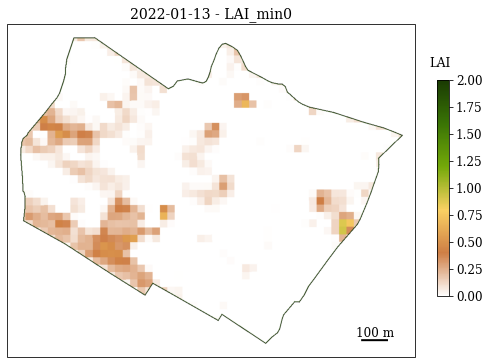

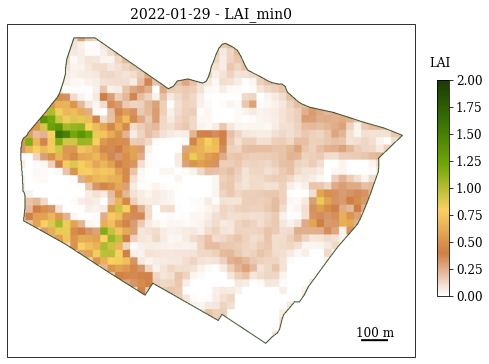

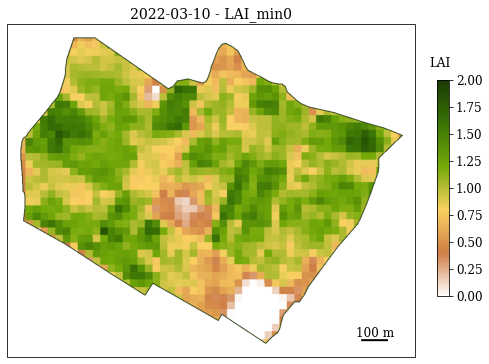

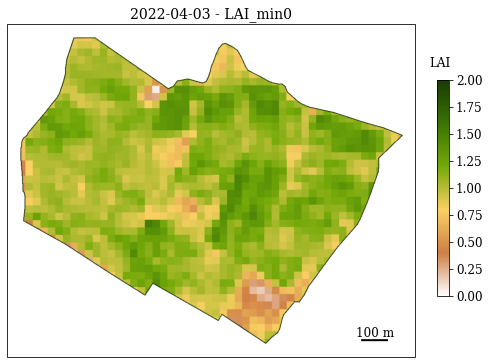

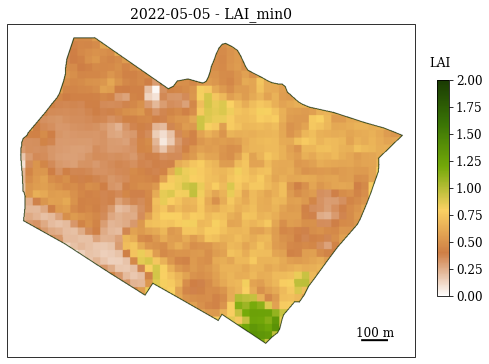

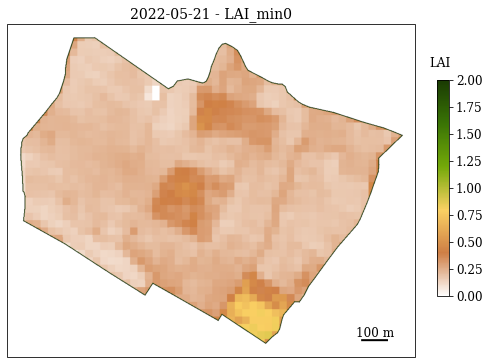

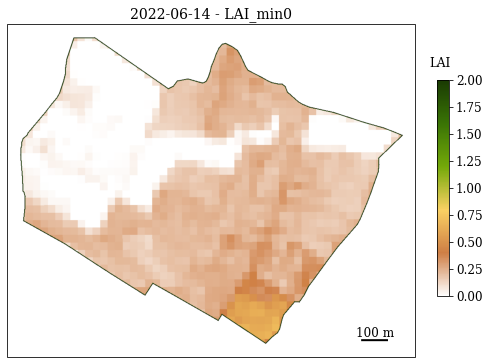

In [30]:
# Generar gráficas de variables determinadas
# ['NDVI',  'SAVI', 'LAI', 'albedo', 'Ts_k', 'Ts_c', 't_sw', 'e_0', 'e_NB', 'cos_theta', 'cos_theta_1', 'slope', 'elevation']
for n_img, img in enumerate(lista_imgprocesadas):

    # img_rgb_sr = img['img_SR']
    img_ = img['img_productos'].select('LAI').clip(predios_agricolas)
    fecha = img['fecha']

    img_productos_dict = get_stats(img_, predios_agricolas, 30)
    img_productos_df = pd.DataFrame.from_dict(img_productos_dict, orient='index') # .round(3)

    vis_params_lai = {
        'min': 0,  
        'max': 2, 
        'palette': ndvi_cmap# cmp.get_palette('cubehelix_r') # RdYlGn_r, afmhot, turbo_r
    }
    
    # vis_params_ndvi = {'min': 0,
    #                    'max': 1,
    #                    'palette': ndvi_cmap}
    
    # vis_params_sr = {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0.0, 'max': 0.3, 'gamma':1.3}
    # vis_params_alb = {
    #     'min': 0,
    #     'max': 0.25,
    #     'palette': ndvi_cmap#cmp.get_palette('gray') 
    # }
    
    title_map = f'{fecha} - LAI_min0'
    
    get_grafica_cartoee_color(img_.blend(predios_vis), 
                                  vis_params_lai,                              
                                  text=None, 
                                  title_map=title_map,
                                  label='LAI', 
                                  save_fig=f'{fecha}_LAI1_min0',
                                  nogrid=True)

In [26]:
vis_params_ndvi = {
    'min': -0.2, # img_productos_dict['min']['NDVI'],
    'max': 1,    # img_productos_dict['max']['NDVI'],
    'palette': ndvi_cmap # cmp.get_palette('RdYlGn')
}

vis_params_lai = {
    'min': 0,  
    'max': img_productos_dict['max']['LAI'], 
    'palette': ndvi_cmap # RdYlGn_r, afmhot, turbo_r
}

img_lai  = img_productos.select('LAI')
img_lai_n = img_lai.updateMask(img_lai.lte(0))

# Mapas
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_rgb, vis_rgb, 'img_rgb')
Map.addLayer(img_ndvi, vis_params_ndvi, 'img_ndvi')
Map.addLayer(img_lai,  vis_params_lai, 'img_lai')
Map.addLayer(img_lai_n, {}, 'img_lai_n')
Map

Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

### Función `recorte_por_percentiles`

In [10]:
def recorte_por_percentiles_alb(n1, n2, img_ndvi, img_albedo, geometry, filtrado=None):
    
    """ Recortar mapas de temperatura en función de mapa NDVI para obtener pixeles candidatos.

    Parametros
    ----------
    n1, n2 : int
    img_ndvi : ee.Image
    img_ts : ee.Image
    geometry : ee.Geometry
    filtrado : str

    Retorna
    -------
    pixeles : ee.Image
        Mapa recortado (por updateMask) de pixeles candidatos.
    """

    # 1. Procesar n1
    # Para NDVI > 0, retorna el percentil n1
    perc_n1 = ee.Number(img_ndvi
                        .updateMask(img_ndvi.gte(0))
                        .reduceRegion(ee.Reducer.percentile([n1]), geometry=geometry, scale=30)
                        .values()
        )
    
    if filtrado == 'cold':
        # Pixel frío
        # Para los valores de ndvi mayores al percentil perc_n1, retornar sus temperaturas
        alb_recortado_p_n1 = img_albedo.updateMask(img_ndvi.gte(perc_n1)) # Albedo
    else: 
        # Pixel caliente
        img_ndvi = img_ndvi.clip(geometry)
        img_albedo = img_albedo.clip(geometry)
        # Para los valores de ndvi menores al percentil perc_n1, retornar sus temperaturas
        alb_recortado_p_n1 = img_albedo.updateMask(img_ndvi.lte(perc_n1))
        
    # 2. Procesar n2
    perc_n2 = ee.Number(alb_recortado_p_n1
                        .reduceRegion(ee.Reducer.percentile([n2]), geometry=geometry, scale=30)
                        .values()
        )
    
    if filtrado == 'cold':
        # Los valores más bajos de temperatura
        # Los valores más altos de albedo
        pixeles = alb_recortado_p_n1.updateMask(alb_recortado_p_n1.gte(perc_n2))
    else:
        # Los valores más altos de temperatura
        # Los valores más bajos de albedo
        pixeles = alb_recortado_p_n1.updateMask(alb_recortado_p_n1.lte(perc_n2))
            
    return pixeles

### Pixeles Fríos

Pixeles Fríos: 
Encontrar el grupo de pixeles con
- NDVI alto
- Temperatura superficial baja

Procedimiento:
- Obtener percentil n1 para imagen NDVI con valores positivos [(ee.Reducer.percentile)](https://developers.google.com/earth-engine/apidocs/ee-reducer-percentile)
- Obtener valores de NDVI > n1 
- Recortar mapa de temperatura para valores Ts < $n_2$ en función de valores de NDVI > $n_1$
- Seleccionar un pixel y anotar coordenadas

In [6]:
# Selección de Pixel Frío - Recorte de mapas

# 0 '2022-01-13' n1: 50 n2: 10
# 1 '2022-01-29' n1: 50 n2: 10
# 2 '2022-03-10' n1: 50 n2: 5
# 3 '2022-04-03' n1: 80 n2: 10
# 4 '2022-05-05' n1: 40 n2: 10
# 5 '2022-05-21' n1: 50 n2: 10
# 6 '2022-06-14' n1: 50 n2: 5

perc_ndvi =  80  # n1: Percentil para NDVI
perc_temp =  80  # n2: Percentil para albedo

# Procesado de imagen
pixeles_frios = recorte_por_percentiles_alb(perc_ndvi, perc_temp, 
                                            img_ndvi, img_albedo, geometry=predios_agricolas, 
                                            filtrado='cold')

# Estadisticas
pixeles_frios_stats = get_stats(pixeles_frios, predios_agricolas, 30)

# =============================================================
# Visualizar
# ============================================================= 

# 1. Inputs para gráfico con geemap
paleta = 'YlGn'#'RdYlBu'  # Rampa de color azul y rojo
# paleta = 'binary_r'  # Color negro indica el pixel más frío

vis_params_pix = {
    'min': pixeles_frios_stats['min']['albedo'],
    'max': pixeles_frios_stats['max']['albedo'],
    'palette': cmp.get_palette(paleta) #ndvi_cmap 
}

image = pixeles_frios.blend(predios_vis)

print(lista_imgprocesadas[index]['fecha'])

# 2. Visualización con geemap
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)

Map.addLayer(img_rgb, vis_rgb, 'RGB TOA')
Map.addLayer(img_tempC, vis_params_ts, 'img_ts')
Map.addLayer(img_albedo, vis_params_alb, 'img albedo')
Map.addLayer(img_ndvi, vis_params_ndvi, 'img_ndvi')
Map.addLayer(image, vis_params_pix, 'Pixeles')

# Coordenadas previamente seleccionados (Pixel Frio)
list_coords_pixf = [
    [-79.775487, -6.601604],  # 0 '2022-01-13' n1: 50 n2: 10
    [-79.785809, -6.598078],  # 1 '2022-01-29' n1: 50 n2: 10
    [-79.782536, -6.601574],  # 2 '2022-03-10' n1: 50 n2: 5
    [-79.782545, -6.601342], # 3 '2022-04-03' n1: 80 n2: 10 
    [-79.778744, -6.604585], # 4 '2022-05-05' n1: 40 n2: 10
    [-79.778718, -6.604593], # 5 '2022-05-21' n1: 50 n2: 10
    [-79.778739, -6.604574], # 6 '2022-06-14' n1: 50 n2: 5
]

# Coordenadas previamente seleccionados (Pixel Caliente)
list_coords_pixc = [
    [-79.778176, -6.605123],  # 0 '2022-01-13' n1: 50 n2: 10
    [-79.778717, -6.604576],  # 1 '2022-01-29' n1: 50 n2: 10
    [-79.778736, -6.604317],  # 2 '2022-03-10' n1: 50 n2: 5
    [-79.778468, -6.603759],  # 3 '2022-04-03' n1: 80 n2: 10
    [-79.782006, -6.598379], # 4 '2022-05-05' n1: 40 n2: 10 
    [-79.78228, -6.596453], # 5 '2022-05-21' n1: 50 n2: 10
    [-79.784462, -6.59621], # 6 '2022-06-14' n1: 50 n2: 5
]

Map.addLayer(ee.Geometry.Point(list_coords_pixf[index]), {}, 'Pixel F')
Map.addLayer(ee.Geometry.Point(list_coords_pixc[index]), {}, 'Pixel C')

# Map.add_colorbar(vis_params_pix, orientation='vertical', label='Pixeles [°C]')
Map

2022-01-13


Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

In [49]:
# ===================================================================================================
# Selección de pixel frío
# 1. Ubica el pixel frío en el mapa y coloca un marker con la opción "draw a marker"
# 2. Una vez ubicado, correr la línea de abajo para obtener sus coordenadas [longitud, latitud]
# ===================================================================================================

Map.user_rois.geometry().coordinates().getInfo() 
# PixC [-79.784183, -6.596201]

[[-79.784462, -6.59621], [-79.778739, -6.604574]]

In [34]:
lista_pixeles = [[-79.781188, -6.597254],
 [-79.781464, -6.596444],
 [-79.782545, -6.60132],
 [-79.77794, -6.596974],
 [-79.775491, -6.599975]]

for pixel in lista_pixeles:
    pixf_ee_coord = ee.Geometry.Point(pixel)
    pprint(get_pixel_values(pixf_ee_coord, d2, img_productos))

{'Albedo': 0.18919493391900044,
 'Elev_m': 46,
 'G': 86.35100346713324,
 'LAI': 1.3702012616807735,
 'NDVI': 0.7111931119311191,
 'R_n': 625.0357197343591,
 'SAVI': 0.5204344820402325,
 'Slope_d': 0.9335907697677612,
 'T_sw': 0.7583149110836516,
 'Ts_c': 14.479494257364593,
 'Ts_k': 287.62949425736457,
 'cos_theta': 0.8520663683717258,
 'e_0': 0.9637020126168077}
{'Albedo': 0.19020936565147673,
 'Elev_m': 46,
 'G': 89.20651539724177,
 'LAI': 1.3839181538299294,
 'NDVI': 0.7121879588839941,
 'R_n': 648.6521680933619,
 'SAVI': 0.5225379067137665,
 'Slope_d': 2.7987873554229736,
 'T_sw': 0.7576606473438545,
 'Ts_c': 14.749357857032521,
 'Ts_k': 287.8993578570325,
 'cos_theta': 0.8823677669781348,
 'e_0': 0.9638391815382993}
{'Albedo': 0.1889383608586941,
 'Elev_m': 46,
 'G': 82.97095770834201,
 'LAI': 1.522038027424773,
 'NDVI': 0.7413954404451228,
 'R_n': 631.2034439339866,
 'SAVI': 0.5423170225656415,
 'Slope_d': 0,
 'T_sw': 0.7579039107647978,
 'Ts_c': 14.64788019191542,
 'Ts_k': 287.7

In [29]:
# Coordenadas previamente seleccionados (Pixel Frio)
list_coords_pixf = [
    [-79.775487, -6.601604],  # 0 '2022-01-13' n1: 50 n2: 10
    [-79.785809, -6.598078],  # 1 '2022-01-29' n1: 50 n2: 10
    [-79.782536, -6.601574],  # 2 '2022-03-10' n1: 50 n2: 5
    [-79.778468, -6.603759], # 3 '2022-04-03' n1: 80 n2: 10
    [-79.782006, -6.598379], # 4 '2022-05-05' n1: 40 n2: 10
    [-79.778718, -6.604593], # 5 '2022-05-21' n1: 50 n2: 10
    [-79.778739, -6.604574], # 6 '2022-06-14' n1: 50 n2: 5
]

# Coordenadas previamente seleccionados (Pixel Caliente)
list_coords_pixc = [
    [-79.778176, -6.605123],  # 0 '2022-01-13' n1: 50 n2: 10
    [-79.778717, -6.604576],  # 1 '2022-01-29' n1: 50 n2: 10
    [-79.778736, -6.604317],  # 2 '2022-03-10' n1: 50 n2: 5
    [-79.782545, -6.601342],  # 3 '2022-04-03' n1: 80 n2: 10
    [-79.778744, -6.604585], # 4 '2022-05-05' n1: 40 n2: 10
    [-79.78228, -6.596453], # 5 '2022-05-21' n1: 50 n2: 10
    [-79.784462, -6.59621], # 6 '2022-06-14' n1: 50 n2: 5
]

# list_coords_pixf = [
#     [-79.78527, -6.598056],  # 0 '2022-01-13' n1: 50 n2: 10
#     [-79.78472, -6.598345],  # 1 '2022-01-29' n1: 50 n2: 10
#     [-79.78445, -6.596984],  # 2 '2022-03-10' n1: 50 n2: 5
#     [-79.779022, -6.597242], # 3 '2022-04-03' n1: 80 n2: 10
#     [-79.776047, -6.597519], # 4 '2022-05-05' n1: 40 n2: 10
#     [-79.778976, -6.605092], # 5 '2022-05-21' n1: 50 n2: 10
#     [-79.778737, -6.604828], # 6 '2022-06-14' n1: 50 n2: 5
# ]

pixf_coord = list_coords_pixf[index]
pixf_ee_coord = ee.Geometry.Point(pixf_coord)

pix_c_values = get_pixel_values(pixf_ee_coord, d2, img_productos)

display(pix_c_values)

{'Albedo': 0.14419593049091683,
 'Elev_m': 44,
 'G': 90.32934668718602,
 'LAI': 0.471268393890954,
 'NDVI': 0.509179839795846,
 'R_n': 653.2231837800008,
 'SAVI': 0.30575963839063286,
 'Slope_d': 0.9274099469184875,
 'T_sw': 0.737355258904794,
 'Ts_c': 19.699221805369973,
 'Ts_k': 292.84922180536995,
 'cos_theta': 0.8391784430663471,
 'e_0': 0.9547126839389095}

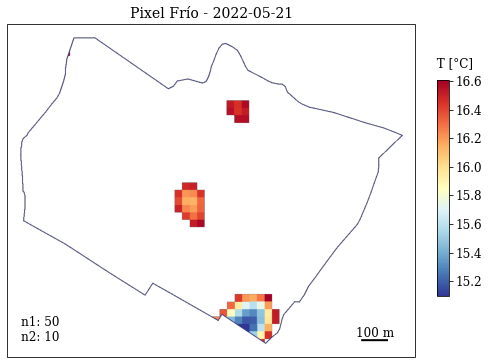

In [103]:
# 1. Inputs para gráfico con geemap
paleta = 'RdYlBu_r'  # Rampa de color azul y rojo
# paleta = 'binary_r'  # Color negro indica el pixel más frío

vis_params_pix = {
    'min': pixeles_frios_stats['min']['Ts_C'],
    'max': pixeles_frios_stats['max']['Ts_C'],
    'palette': cmp.get_palette(paleta)
}

image = pixeles_frios_C.blend(predios_vis)
title_map = f'Pixel Frío - {fecha}'

get_grafica_cartoee_color(image, 
                          vis_params_pix, 
                          title_map=title_map,
                          text=f'n1: {perc_ndvi}\nn2: {perc_temp}',
                          nogrid=True,
                          label="  T [°C]",
                          save_fig= f'imagenes/{fecha}_Pix_F'
)

### Pixeles Calientes

- The “hot” pixel should be located in a dry and bare agricultural field where one can
assume there is no evapotranspiration taking place.
-  It is recommended that one no use:
    - a hot desert area
    - an asphalt parking lot
    - a roof
    - a south facing mountain slope
    - or other such extremely hot areas
since the relationship between dT and Ts may not
follow the same linear relation as for agricultural and bare agricultural soils.ils.

In [15]:
# Selección de Pixel Caliente - Recorte de mapas

# 0 '2022-01-13' n1: 40 n2: 97
# 1 '2022-01-29' n1: 10 n2: 90
# 2 '2022-03-10' n1: 4  n2: 75 
# 3 '2022-04-03' n1: 10 n2: 80
# 4 '2022-05-05' n1: 25 n2: 75
# 5 '2022-05-21' n1: 30 n2: 80
# 6 '2022-06-14' n1: 10 n2: 80

perc_ndvi = 40  # n1 : Percentil para NDVI
perc_temp = 97  # n2 : Percentil para temperatura

pixeles_hot_K = recorte_por_percentiles(perc_ndvi, 
                                        perc_temp, 
                                        img_ndvi, img_tempK, 
                                        geometry=predios_agricolas) # [K]
pixeles_hot_C = pixeles_hot_K.subtract(273.15) # [°C]

pixeles_hot_stats = get_stats(pixeles_hot_C, predios_agricolas, 30)
# display(pd.DataFrame.from_dict(pixeles_hot_stats, orient='index'))

# Obtener gráfica con cartoee
paleta = 'RdYlBu_r' # RdYlBu_r o binary_r # Color negro o rojo el pixel más caliente

vis_params_pix = {
    'min': pixeles_hot_stats['min']['Ts_k'],
    'max': pixeles_hot_stats['max']['Ts_k'],
    'palette': cmp.get_palette(paleta) 
}

print(lista_imgprocesadas[index]['fecha'])
image = pixeles_hot_C.blend(predios_vis) # predios_vis, ee_RectangleVis

# Visualización
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_rgb, vis_rgb, 'RGB TOA')

Map.addLayer(img_albedo, vis_params_alb, 'albedo')
Map.addLayer(img_tempC, vis_params_ts, 'img_tempC')
Map.addLayer(img_ndvi, vis_params_ndvi, 'img_ndvi')
Map.addLayer(image, vis_params_pix, 'Pixeles C')
Map.addLayer(image, vis_params_pix, 'Pixeles C')

vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 

Map.addLayer(ee.Geometry.Point([-79.78527, -6.598056]), {}, 'pixel f')
Map.addLayer(ee.Geometry.Point([-79.78198, -6.602693]), {}, 'pixel c')

# Map.add_colorbar(vis_params_ts,  orientation="horizontal", label="img Ts [°C]")
Map.add_colorbar(vis_params_pix, orientation='vertical', label='Pixeles [°C]')
Map

2022-01-13


Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

In [14]:
# ===================================================================================================
# Selección de pixel caliente
# 1. Ubica el pixel caliente en el mapa y coloca un marker con la opción "draw a marker"
# 2. Una vez ubicado, correr la línea de abajo para obtener sus coordenadas [longitud, latitud]
# ===================================================================================================

Map.user_rois.geometry().coordinates().getInfo() 

[-79.784448, -6.598642]

In [50]:
list_coords_pixc = [
    [-79.78198, -6.602693],  # 0 '2022-01-13' n1: 40 n2: 97 
    [-79.778464, -6.605114], # 1 '2022-01-29' n1: 10 n2: 90
    [-79.777924, -6.604045], # 2 '2022-03-10' n1: 4 n2: 75 
    [-79.778463, -6.603747], # 3 '2022-04-03' n1: 10 n2: 80  
    [-79.784448, -6.598642], # 4 '2022-05-05' n1: 25 n2: 75  
    [-79.785537, -6.598398], # 5 '2022-05-21' n1: 30 n2: 80  
    [-79.784729, -6.595629], # 6 '2022-06-14' n1: 10 n2: 80 
]

pixc_coord = list_coords_pixc[index]
pixc_ee_coord = ee.Geometry.Point(pixc_coord)

pix_h_values = get_pixel_values(pixc_ee_coord, d2, img_productos)
pix_h_values

{'Albedo': 0.10083496165600218,
 'Elev_m': 46,
 'G': 77.20636444733555,
 'LAI': 1.7779653414479464,
 'NDVI': 0.347028613352898,
 'R_n': 636.5881091422093,
 'SAVI': 0.17604746587338813,
 'Slope_d': 1.315826416015625,
 'T_sw': 0.6733418640731811,
 'Ts_c': 15.865663895426906,
 'Ts_k': 289.0156638954269,
 'e_0': 0.9677796534144795}

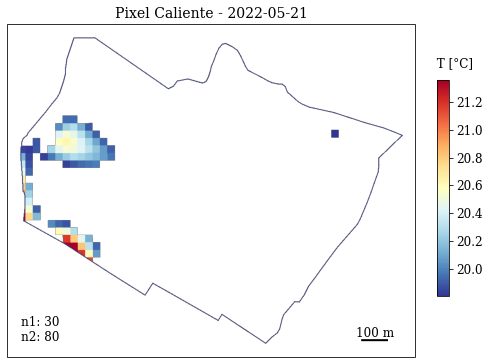

In [109]:
# Obtener gráfica con cartoee
paleta = 'RdYlBu_r' # RdYlBu_r o binary_r # Color negro o rojo el pixel más caliente

vis_params_pix_c = {
    'min': pixeles_hot_stats['min']['Ts_k'],
    'max': pixeles_hot_stats['max']['Ts_k'],
    'palette': cmp.get_palette(paleta) 
}

image = pixeles_hot_C.blend(predios_vis) 
title_map = f'Pixel Caliente - {fecha}'

get_grafica_cartoee_color(image, 
                          vis_params_pix_c, 
                          title_map=title_map,
                          text=f'n1: {perc_ndvi}\nn2: {perc_temp}',
                          nogrid=True,
                          label="  T [°C]",
                          save_fig= f'imagenes/{fecha}_Pix_C'
)

### Pruebas

In [ ]:
# # Selección de Pixel Frío - Recorte de mapas (temperaturas y ndvi)

# # 0 '2022-01-13' n1: 50 n2: 10
# # 1 '2022-01-29' n1: 50 n2: 10
# # 2 '2022-03-10' n1: 50 n2: 5
# # 3 '2022-04-03' n1: 80 n2: 10
# # 4 '2022-05-05' n1: 40 n2: 10
# # 5 '2022-05-21' n1: 50 n2: 10
# # 6 '2022-06-14' n1: 50 n2: 5

# perc_ndvi =  50  # n1: Percentil para NDVI
# perc_temp =  10  # n2: Percentil para temperatura

# # Procesado de imagen
# pixeles_frios_K = recorte_por_percentiles(perc_ndvi, perc_temp, 
#                                           img_ndvi, img_tempK, geometry=predios_agricolas, 
#                                           filtrado='cold') # [K]
# pixeles_frios_C = pixeles_frios_K.subtract(273.15).rename('Ts_C') # [°C]

# # Estadisticas
# pixeles_frios_stats = get_stats(pixeles_frios_C, predios_agricolas, 30)

# # =============================================================
# # Visualizar
# # ============================================================= 

# # 1. Inputs para gráfico con geemap
# paleta = 'RdYlBu_r'  # Rampa de color azul y rojo
# # paleta = 'binary_r'  # Color negro indica el pixel más frío

# vis_params_pix = {
#     'min': pixeles_frios_stats['min']['Ts_C'],
#     'max': pixeles_frios_stats['max']['Ts_C'],
#     'palette': cmp.get_palette(paleta)
# }

# image = pixeles_frios_C.blend(predios_vis)

# print(lista_imgprocesadas[index]['fecha'])

# # 2. Visualización con geemap
# Map = geemap.Map()
# Map.centerObject(predios_agricolas, 16)

# Map.addLayer(img_rgb, vis_rgb, 'RGB TOA')
# Map.addLayer(img_tempC, vis_params_ts, 'img Ts °C')
# Map.addLayer(img_ndvi, vis_params_ndvi, 'img_ndvi')
# Map.addLayer(image, vis_params_pix, 'Pixeles')

# Map.addLayer(ee.Geometry.Point([-79.778976, -6.605092]), {}, 'Pixel')

# Map.add_colorbar(vis_params_pix, orientation='vertical', label='Pixeles [°C]')
# Map

In [ ]:
# Coordenadas previamente seleccionados (Pixel Frio)
list_coords_pixf = [
    [-79.78527, -6.598056],  # 0 '2022-01-13' n1: 50 n2: 10
    [-79.78472, -6.598345],  # 1 '2022-01-29' n1: 50 n2: 10
    [-79.78445, -6.596984],  # 2 '2022-03-10' n1: 50 n2: 5
    [-79.779022, -6.597242], # 3 '2022-04-03' n1: 80 n2: 10
    [-79.776047, -6.597519], # 4 '2022-05-05' n1: 40 n2: 10
    [-79.778976, -6.605092], # 5 '2022-05-21' n1: 50 n2: 10
    [-79.778737, -6.604828], # 6 '2022-06-14' n1: 50 n2: 5
]

pixf_coord = list_coords_pixf[index]
pixf_ee_coord = ee.Geometry.Point(pixf_coord)

pix_c_values = get_pixel_values(pixf_ee_coord, d2, img_productos)

display(pix_c_values)

### Gráficas

In [33]:
index = 3 # 0 1 Enero, 2 Marzo, 3 Junio 

img_productos = lista_imgprocesadas[index]['img_productos']

fecha = lista_imgprocesadas[index]['fecha']
# img_productos.clip(predios_agricolas)

d2 = lista_imgprocesadas[index]['d2']
img_ndvi = img_productos.select('NDVI')
img_savi = img_productos.select('SAVI')
img_lai  = img_productos.select('LAI')
img_albedo = img_productos.select('albedo')
img_tempC = img_productos.select('Ts_c')
img_tempK = img_productos.select('Ts_k')
img_slope = img_productos.select('slope')

cos_theta_rel = img_productos.select('cos_theta')
t_sw = img_productos.select('t_sw')
e_0  = img_productos.select('e_0')

# Estadísticas
img_productos_dict = get_stats(img_productos, predios_agricolas, 30)
img_productos_df = pd.DataFrame.from_dict(img_productos_dict, orient='index') # .round(3)
display(img_productos_df)

vis_params_ndvi = {
    'min': -0.2, # img_productos_dict['min']['NDVI'],
    'max': 1,    # img_productos_dict['max']['NDVI'],
    'palette': ndvi_cmap # cmp.get_palette('RdYlGn')
}

vis_params_savi = {
    'min': img_productos_dict['min']['SAVI'],
    'max': img_productos_dict['max']['SAVI'],
    'palette': ndvi_cmap # cmp.get_palette('RdYlGn')
}

vis_params_alb = {
    'min': 0,
    'max': 0.25,
    'palette': cmp.get_palette('cubehelix') 
}

vis_params_ts = {
    'min': img_productos_dict['min']['Ts_c'],
    'max': img_productos_dict['max']['Ts_c'],
    'palette':cmp.get_palette('RdYlBu_r')
}

vis_params_lai = {
    'min': 0,  
    'max': img_productos_dict['max']['LAI'], 
    'palette': cmp.get_palette('cubehelix_r') # RdYlGn_r, afmhot, turbo_r
}

,LAI,NDVI,SAVI,Ts_c,Ts_k,albedo,cos_theta,e_0,e_NB,elevation,slope,t_sw
max,2.463521,0.564996,0.374299,31.605628,304.755628,0.314653,0.807201,0.974635,0.978130,54.000000,6.230337,0.659318
mean,1.699559,0.264333,0.169094,28.373553,301.523553,0.190869,0.766321,0.966996,0.975609,46.121525,1.692146,0.659183
median,1.669874,0.278310,0.188720,27.978548,301.138559,0.192801,0.764497,0.966705,0.975517,46.000000,1.860307,0.659183
min,1.608074,0.085178,0.035070,23.808969,296.958969,0.085689,0.723844,0.966081,0.975307,40.000000,0.000000,0.659058
mode,1.608493,0.286231,0.206115,26.891828,300.043907,0.202663,0.763783,0.966093,0.975308,45.000000,0.930368,0.659181
stdDev,0.131976,0.089286,0.065265,1.620770,1.620770,0.042765,0.014448,0.001320,0.000436,2.046017,0.960372,0.000038


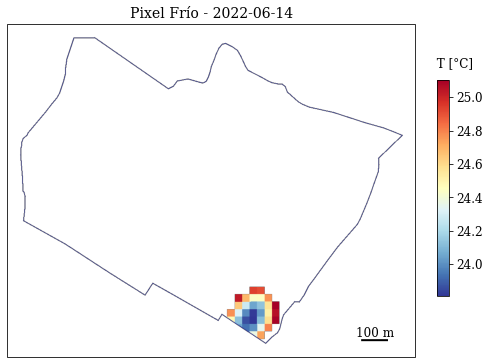

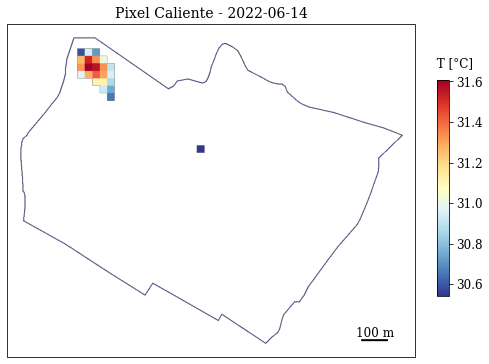

In [34]:
# Pixel frio
# 0 '2022-01-13' n1: 50 n2: 10
# 1 '2022-01-29' n1: 50 n2: 10
# 2 '2022-03-10' n1: 50 n2: 5
# 3 '2022-06-14' n1: 50 n2: 5

# Selección de Pixel Frío - Recorte de mapas
perc_ndvi =  50  # n1 : Percentil para NDVI
perc_temp =  5   # n2 : Percentil para temperatura

# Procesado de imagen
pixeles_f_K = recorte_por_percentiles(perc_ndvi, 
                                      perc_temp, 
                                      img_ndvi, 
                                      img_tempK, 
                                      geometry=predios_agricolas, 
                                      filtrado='cold') # [K]
pixeles_f_C = pixeles_f_K.subtract(273.15).rename('Ts_C') # [°C]
pixeles_f_stats = get_stats(pixeles_f_C, predios_agricolas, 30)

# Pixel caliente
# 0 '2022-01-13' n1: 40 n2: 97
# 1 '2022-01-29' n1: 50 n2: 70
# 2 '2022-03-10' n1: 4 n2: 80 
# 3 '2022-06-14' n1: 10 n2: 80

# Selección de Pixel Caliente - Recorte de mapas
perc_ndvi = 10  # n1 : Percentil para NDVI
perc_temp = 80 # n2 : Percentil para temperatura

pixeles_c_K = recorte_por_percentiles(perc_ndvi, 
                                        perc_temp, 
                                        img_ndvi, 
                                        img_tempK, 
                                        geometry=predios_agricolas) # [K]
pixeles_c_C = pixeles_c_K.subtract(273.15) # [°C]
pixeles_c_stats = get_stats(pixeles_c_C, predios_agricolas, 30)

# 1. Inputs para gráfico con geemap
path = 'imagenes/pixeles'

# Pixel Frio
paleta = 'RdYlBu_r' # Rampa de color azul y rojo
vis_params_pixf = {
    'min': pixeles_f_stats['min']['Ts_C'],
    'max': pixeles_f_stats['max']['Ts_C'],
    'palette': cmp.get_palette(paleta)
}

image = pixeles_f_C.blend(predios_vis)
title_map = f'Pixel Frío - {fecha}'

get_grafica_cartoee_color(image, 
                          vis_params_pixf, 
                          title_map=title_map,
                          text=f'n1: {perc_ndvi}\nn2: {perc_temp}',
                          nogrid=True,
                          label="  T [°C]",
                          save_fig=f'{path}/{fecha}_Pix_F'
)

# Pixel Caliente
paleta = 'RdYlBu_r' # Color rojo el pixel más caliente
vis_params_pixc = {
    'min': pixeles_c_stats['min']['Ts_k'],
    'max': pixeles_c_stats['max']['Ts_k'],
    'palette': cmp.get_palette(paleta) 
}

title_map = f'Pixel Caliente - {fecha}'
image = pixeles_c_C.blend(predios_vis)

get_grafica_cartoee_color(image, 
                          vis_params_pixc, 
                          title_map=title_map,
                          text=f'n1: {perc_ndvi}\nn2: {perc_temp}',
                          nogrid=True,
                          label="  T [°C]",
                          save_fig=f'{path}/{fecha}_Pix_C'
)